In [85]:
import pandas as pd

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MolFromSmiles

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import numpy as np

import pickle

from xgboost import XGBRegressor

## Load drug solubility dataset
(Data from https://www.kaggle.com/competitions/drug-solubility-challenge/)

In [86]:
solubility_df = pd.read_csv('data/delaney-processed.csv', header=0, sep=',')
solubility_df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


## Let's create our own features

In [87]:
solubility_df['Mol'] = solubility_df['smiles'].apply(MolFromSmiles)
print(solubility_df.shape)
solubility_df = solubility_df.dropna(subset=['Mol'])
print(solubility_df.shape)

calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])

X = [calc.CalcDescriptors(mol) for mol in solubility_df['Mol']]
Y = solubility_df['measured log solubility in mols per litre'].values

(1128, 11)
(1128, 11)


## Save new dataset with the new features for future use

In [88]:
new_df = pd.DataFrame(X, columns=calc.GetDescriptorNames())
new_df['smiles'] = solubility_df.smiles.values
new_df['logS'] = Y
new_df.to_csv('data/processed_logs.csv', sep=',', index=False)

## Train-test Split

In [89]:
X = new_df.drop(columns=['smiles', 'logS'])
Y = new_df['logS']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model 1 (Linear Regression)

Lets build a simple Linear Regression Model!

In [90]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Model predictions

In [91]:
Y_pred = model.predict(X_test)
Y_pred

array([ -2.12921076,  -2.51219387,  -2.50517025,  -2.12921076,
        -6.62999978,  -0.95839517,  -3.63330202,  -3.36681919,
        -8.66837505,  -2.39683934,  -5.54109373,   1.08524577,
        -3.48091817,  -2.00482013,  -3.6099841 ,  -0.42527866,
        -2.41283659, -12.53484875,  -4.04931594,  -3.74411183,
        -1.7465381 ,  -5.80656006,   0.97936017,  -2.28950264,
        -1.47962043,  -7.48147859,  -0.34584535,   0.15832718,
        -0.48900805,  -2.03679675,  -1.6250835 ,  -7.51396121,
        -3.49678905,  -1.95962968,  -2.37221471,  -2.72507124,
        -4.17903735,  -0.20961646,  -4.64568853,  -8.34157895,
        -1.25465912,  -7.01794506,  -3.97678455,  -5.87714097,
        -7.87959642,  -4.56400012,  -4.32437211,  -4.10046748,
        -4.75017242,  -9.09463942,  -4.6696522 ,  -7.6642275 ,
        -1.5337947 ,  -2.27973729,  -0.90933154,  -4.21303865,
        -2.06403882,  -3.53662096,  -3.02706415,  -6.44594339,
        -2.92480429,  -2.52338278,   0.21538282,  -6.59

## Model Performance

In [93]:
print(f'Mean squared error (MSE): {mean_squared_error(y_test, Y_pred)}')
print(f'Coefficient of determination (R^2): {r2_score(y_test, Y_pred)}')

Mean squared error (MSE): 0.4728378906929895
Coefficient of determination (R^2): 0.899966670553427


## Data Visualization (Experimental vs Predicted LogS for Test Data)

Text(0.5, 0, 'Experimental LogS')

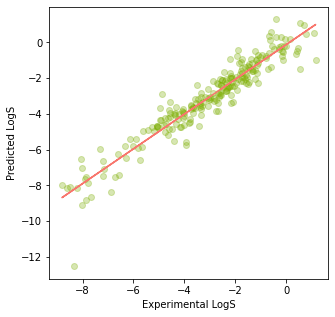

In [94]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_test, y=Y_pred, c="#7CAE00", alpha=0.3)

# Add trendline
z = np.polyfit(y_test, Y_pred, 1)
p = np.poly1d(z)

plt.plot(y_test,p(y_test),"#F8766D")
plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

## save model as a pickle file

In [95]:
pickle.dump(model, open('models/solubility_model.pkl', 'wb'))

## Model 2 (xgboost)

Lets build a simple xgboost Model!

In [96]:
xgbr = XGBRegressor()
# fit model
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

## Model predictions

In [97]:
Y_pred = xgbr.predict(X_test)
Y_pred

array([-2.6227431 , -1.7691919 , -2.519029  , -2.6227431 , -7.190096  ,
       -0.9374802 , -4.4059925 , -2.3523753 , -8.145546  , -2.9410872 ,
       -4.5553193 , -1.2390354 , -3.436229  , -2.2354476 , -2.5452437 ,
       -0.66163814, -2.374628  , -7.8321815 , -3.126877  , -3.7628944 ,
       -1.0607979 , -5.83985   ,  0.9685371 , -1.2499553 , -1.2426513 ,
       -7.841024  , -0.36558717,  0.05823075, -1.5076646 , -2.0153396 ,
       -1.6091005 , -7.7587266 , -3.8460305 , -1.6623586 , -2.6514256 ,
       -2.786219  , -3.783751  , -0.14668962, -4.651615  , -7.0136666 ,
       -1.298066  , -7.291782  , -4.8915763 , -5.6058664 , -8.291172  ,
       -4.5189047 , -4.0080657 , -3.7722013 , -4.7053566 , -6.999053  ,
       -5.1396737 , -6.189788  , -1.1931275 , -2.2870102 , -0.87593937,
       -4.4362354 , -1.573188  , -3.1106548 , -2.3822513 , -5.715529  ,
       -2.4494193 , -2.3351297 ,  0.24527788, -6.0539284 , -3.9021735 ,
       -3.0262575 , -2.1668782 , -3.8930593 , -2.2178972 , -2.35

## Model Performance

In [98]:
print(f'Mean squared error (MSE): {mean_squared_error(y_test, Y_pred)}')
print(f'Coefficient of determination (R^2): {r2_score(y_test, Y_pred)}')

Mean squared error (MSE): 0.5295552152450466
Coefficient of determination (R^2): 0.8879675839236967


## Data Visualization (Experimental vs Predicted LogS for Test Data)

Text(0.5, 0, 'Experimental LogS')

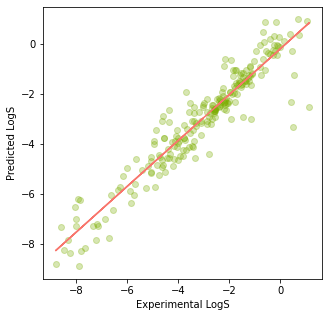

In [99]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_test, y=Y_pred, c="#7CAE00", alpha=0.3)

# Add trendline
z = np.polyfit(y_test, Y_pred, 1)
p = np.poly1d(z)

plt.plot(y_test,p(y_test),"#F8766D")
plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

## save model as a pickle file

In [100]:
# save in JSON format
xgbr.save_model("models/xgboost_regressor.json")